# PyRATES Reproducibility Study

## Koslow et al. (2011) "Impact of declining intermediate-water oxygen on deepwater fishes in the California Current"
[Link to study](https://www.researchgate.net/publication/263583233_Impact_of_declining_intermediate-water_oxygen_on_deepwater_fishes_in_the_California_Current)

Visit README for project description and workflow outline.

***

### 0. Set Up

Load libraries.

In [1]:
import pandas as pd # for data wrangling
import numpy as np # for data wrangling
import matplotlib.pyplot as plt # for plotting

from sklearn.preprocessing import StandardScaler # for standardizing for PCA
from sklearn.decomposition import PCA # for PCA

from scipy.stats import (pearsonr, spearmanr) # to get correlation coefficients

import pyleoclim as pyleo # for detrending

from great_tables import (GT, style, loc, html) # for making tables

***

### 1. Get and Process CalCOFI Ichthyoplankton Data

CalCOFI ichthyoplankton data is hosted here on [ERDDAP](https://coastwatch.pfeg.noaa.gov/erddap/tabledap/erdCalCOFIlrvcnt.html).

The analysis in this paper includes data from 3 species' eggs in addition to the ichthyoplankton data. As of last check on 7/30/24, the link to the CalCOFI egg count positive tows dataset on [calcofi.org](https://calcofi.org/data/marine-ecosystem-data/fish-eggs-larvae/) is giving a 404 error. For now I will just work with the ichthyoplankton data.

Manual step: query ERDDAP.
- check all variables
- constrain the time >= 1951-01-18T00:00:00Z and <= 2008-12-31T23:59:59Z
- download the data as a csv file

Read in the data.

In [2]:
# there is a datetime column; use this as the index
df = pd.read_csv("calcofi-ichthyo.csv",
                 index_col = 7, parse_dates = True)

Check the column names of the data.

In [3]:
display(df.columns)

Index(['cruise', 'ship', 'ship_code', 'order_occupied', 'tow_type',
       'tow_number', 'net_location', 'latitude', 'longitude', 'line',
       'station', 'standard_haul_factor', 'volume_sampled',
       'proportion_sorted', 'scientific_name', 'common_name', 'itis_tsn',
       'calcofi_species_code', 'larvae_count', 'larvae_10m2', 'larvae_100m3'],
      dtype='object')

View the first few rows of the data.

In [4]:
display(df.head())

,cruise,ship,ship_code,order_occupied,tow_type,tow_number,net_location,latitude,longitude,line,...,standard_haul_factor,volume_sampled,proportion_sorted,scientific_name,common_name,itis_tsn,calcofi_species_code,larvae_count,larvae_10m2,larvae_100m3
time,,,,,,,,,,,,,,,,,,,,,
UTC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,degrees_north,degrees_east,NaN,...,NaN,meters^3,NaN,NaN,NaN,NaN,NaN,NaN,Larvae 10/M^2,Larvae 100/M^3
1951-01-19T07:25:00Z,195101.0,SCOFIELD,47,1.0,C1,1.0,S,33.833332,-118.625,86.7,...,1.65,892.6,1.0,Citharichthys,Sanddabs,172715.0,924.0,2.0,3.3,NaN
1951-01-19T07:25:00Z,195101.0,SCOFIELD,47,1.0,C1,1.0,S,33.833332,-118.625,86.7,...,1.65,892.6,1.0,Engraulis mordax,Northern anchovy,161828.0,31.0,103.0,169.95,NaN
1951-01-19T07:25:00Z,195101.0,SCOFIELD,47,1.0,C1,1.0,S,33.833332,-118.625,86.7,...,1.65,892.6,1.0,Gobiidae,Gobies,171746.0,795.0,1.0,1.65,NaN
1951-01-19T07:25:00Z,195101.0,SCOFIELD,47,1.0,C1,1.0,S,33.833332,-118.625,86.7,...,1.65,892.6,1.0,Leuroglossus stilbius,California smoothtongue,162096.0,72.0,134.0,221.1,NaN


Select just the needed columns: line, station, scientific name, and larval abundance.

In [5]:
# get just the columns we need
df = (df.filter(items =["line","station","scientific_name", "larvae_10m2"])
        .dropna())

# show the first few observations in the new dataframe
display(df.head())

,line,station,scientific_name,larvae_10m2
time,,,,
1951-01-19T07:25:00Z,86.7,35.0,Citharichthys,3.3
1951-01-19T07:25:00Z,86.7,35.0,Engraulis mordax,169.95
1951-01-19T07:25:00Z,86.7,35.0,Gobiidae,1.65
1951-01-19T07:25:00Z,86.7,35.0,Leuroglossus stilbius,221.1
1951-01-19T07:25:00Z,86.7,35.0,Lipolagus ochotensis,1.65


Build a dataframe with the lines and stations used in the study.

Note that the text says that 51 stations were used; however, the map in Figure 1 seems to have 55 stations in the outlined region. I am including all 55 of these stations because it is not clear which ones were removed from the study.

In [6]:
# create a DataFrame with lines as columns and stations as rows
stations = pd.DataFrame(
   {"76.7" : [80, 70, 60, 55, 51, 49, pd.NA, pd.NA, pd.NA, pd.NA, pd.NA, pd.NA],
    "80" : [100, 90, 80, 70, 60, 55, 51, pd.NA, pd.NA, pd.NA, pd.NA, pd.NA],
    "81.8" : [46.9, pd.NA, pd.NA, pd.NA, pd.NA, pd.NA, pd.NA, pd.NA, pd.NA, pd.NA, pd.NA, pd.NA],
    "83.3" : [90, 80, 70, 60, 55, 51, 42, 40.6, pd.NA, pd.NA, pd.NA, pd.NA],
    "86.7" : [90, 80, 70, 60, 55, 50, 45, 40, 35, 33, pd.NA, pd.NA],
    "90" : [100, 90, 80, 70, 60, 53, 45, 37, 35, 30, 28, pd.NA],
    "93.3" : [90, 80, 70, 60, 55, 50, 45, 40, 35, 30, 28, 26.7]
    }
)

# melt the df to get a row for each line-station combination
stations = (pd.melt(stations,
                   var_name = "line",
                   value_name = "station")
               .dropna() # now drop the NA values
               .astype('float64') # coerce to float64 to facilitate merging later
               )

# count the number of stations to check there are 55
display(len(stations))

55

Filter for the stations used in the study.

In [7]:
# inner join to keep only the rows with the correct line-stations we are keeping
df2 = (df.reset_index() # move the datetime index to a regular column
        .merge(stations,
               how = "inner",
               left_on = ["line", "station"],
               right_on = ["line", "station"]) # do the merge
        .set_index("time")) # reset the datetime column to index

# count the number of observations at each line-station
observations = df2.groupby(["line","station"]).size()

# count again to check there are still 55 stations
display(len(observations))

# count the number of TAXA currently included
display(len(df2["scientific_name"].unique()))

55

Assign seasons to the dates. In the text, it says Jan-Feb = winter, Mar-May = spring, Jun-Aug = summer, Sep-Dec = fall.

In [9]:
# make sure the index is of datetime type
df2.index = pd.to_datetime(df2.index, utc = True)

# code the seasons based on the month column
df2.loc[df2.index.month.isin([1,2]),"season"] = "Winter"
df2.loc[df2.index.month.isin([3,4,5]),"season"] = "Spring"
df2.loc[df2.index.month.isin([6,7,8]),"season"] = "Summer"
df2.loc[df2.index.month.isin([9,10,11,12]),"season"] = "Fall"

# show the last few rows
display(df2.tail())



,line,station,scientific_name,larvae_10m2,season
time,,,,,
2008-10-26 04:19:00+00:00,81.8,46.9,Engraulis mordax,334.62,Fall
2008-10-26 04:19:00+00:00,81.8,46.9,Neoclinus blanchardi,5.07,Fall
2008-10-26 04:19:00+00:00,81.8,46.9,Protomyctophum crockeri,5.07,Fall
2008-10-26 04:19:00+00:00,81.8,46.9,Sebastes,5.07,Fall
2008-10-26 04:19:00+00:00,81.8,46.9,Synodus lucioceps,5.07,Fall


Remove years with < three seasons of data.

In [10]:
# make a new column with the index year
df2["year"] = df2.index.year

# for each year, count the number of seasons of data present
seasons = (df2.filter(items = ["year", "season"])
           .groupby("year") # group by year
           .nunique() # count the seasons each year has
           .rename(columns = {"season": "count"}) # name the count column "count"
           .reset_index() # ungroup
           )

# drop the years that have less than 3 seasons of data
df3 = df2.drop(
    df2[df2.year.isin(seasons.query("count < 3")["year"])].index # get the index values matching this query
    ) # then drop those rows

# print the years remaining and the years that have been dropped
display(df3["year"].unique())
display(seasons.query("count < 3")["year"])

array([1951, 1952, 1953, 1954, 1955, 1957, 1958, 1959, 1960, 1961, 1962,
       1963, 1964, 1965, 1966, 1969, 1972, 1975, 1978, 1980, 1981, 1984,
       1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995,
       1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006,
       2007, 2008, 1956], dtype=int32)

16    1967
17    1968
20    1974
22    1977
24    1979
27    1982
28    1983
Name: year, dtype: int32

Calculate seasonal means (for each year, each season) of larval abundance.

In [11]:
# make sure the abundance column is numeric
df3["larvae_10m2"] = pd.to_numeric(df3["larvae_10m2"])

# print the data types
display(df3.dtypes)

line               float64
station            float64
scientific_name     object
larvae_10m2        float64
season              object
year                 int32
dtype: object

In [12]:
# group by year, season, and taxa. then take the mean of the larval abundance
seasonalMeans = (df3.filter(["year","season","scientific_name","larvae_10m2"])
                 .groupby(["year","season","scientific_name"]) # group by year, season, taxa
                 .mean() # take the mean of larvae_10m2
                 .reset_index() # ungroup
                 )

# show the first few rows
display(seasonalMeans.head())

,year,season,scientific_name,larvae_10m2
0,1951,Fall,Bathylagoides wesethi,5.700000
1,1951,Fall,Brama japonica,6.680000
2,1951,Fall,Ceratoscopelus townsendi,7.066667
3,1951,Fall,Chauliodus macouni,2.940000
4,1951,Fall,Chromis punctipinnis,6.870000


Calculate annual means of larval abundance.

In [13]:
# group by year and taxa, then take the mean of the seasonal abundances
annualMeans = (seasonalMeans.filter(["year", "scientific_name", "larvae_10m2"])
               .groupby(["year", "scientific_name"]) # group by year and taxa
               .mean() # take the mean of larvae_10m2
               .reset_index() # ungroup
               )

# show the last few rows
display(annualMeans.tail())

,year,scientific_name,larvae_10m2
5759,2008,Trachurus symmetricus,11.462500
5760,2008,Triphoturus mexicanus,15.780282
5761,2008,Vinciguerria lucetia,13.550469
5762,2008,Xeneretmus latifrons,23.549718
5763,2008,Zaniolepis frenata,7.329231


Remove species with data in < half the years. We should end up with larval abundance observations for roughly 86 taxa.

In [14]:
# for each taxon, count how many years of data they have
yearsOfData = (annualMeans.filter(["year", "scientific_name"])
               .groupby(["scientific_name"]) # group by taxa
               .nunique() # count the number of years each taxon has
               .rename(columns = {"year": "count"}) # name the count column "count"
               .reset_index() # ungroup
               )

# drop taxa with years of data less than the threshold (29, half the length of the time series)
annualMeans = annualMeans.drop(
    annualMeans[annualMeans.scientific_name.isin(
        yearsOfData.query("count < 29")["scientific_name"]
        )].index # get the index values matching this query
    ) # then drop those rows

# count the taxa remaining
display(len(annualMeans["scientific_name"].unique()))

93

We still have 93 taxa. The paper does not say another specific condition for choosing taxa to keep. Let's plot the timeseries of annual abundance for each species just to see if anything stands out.

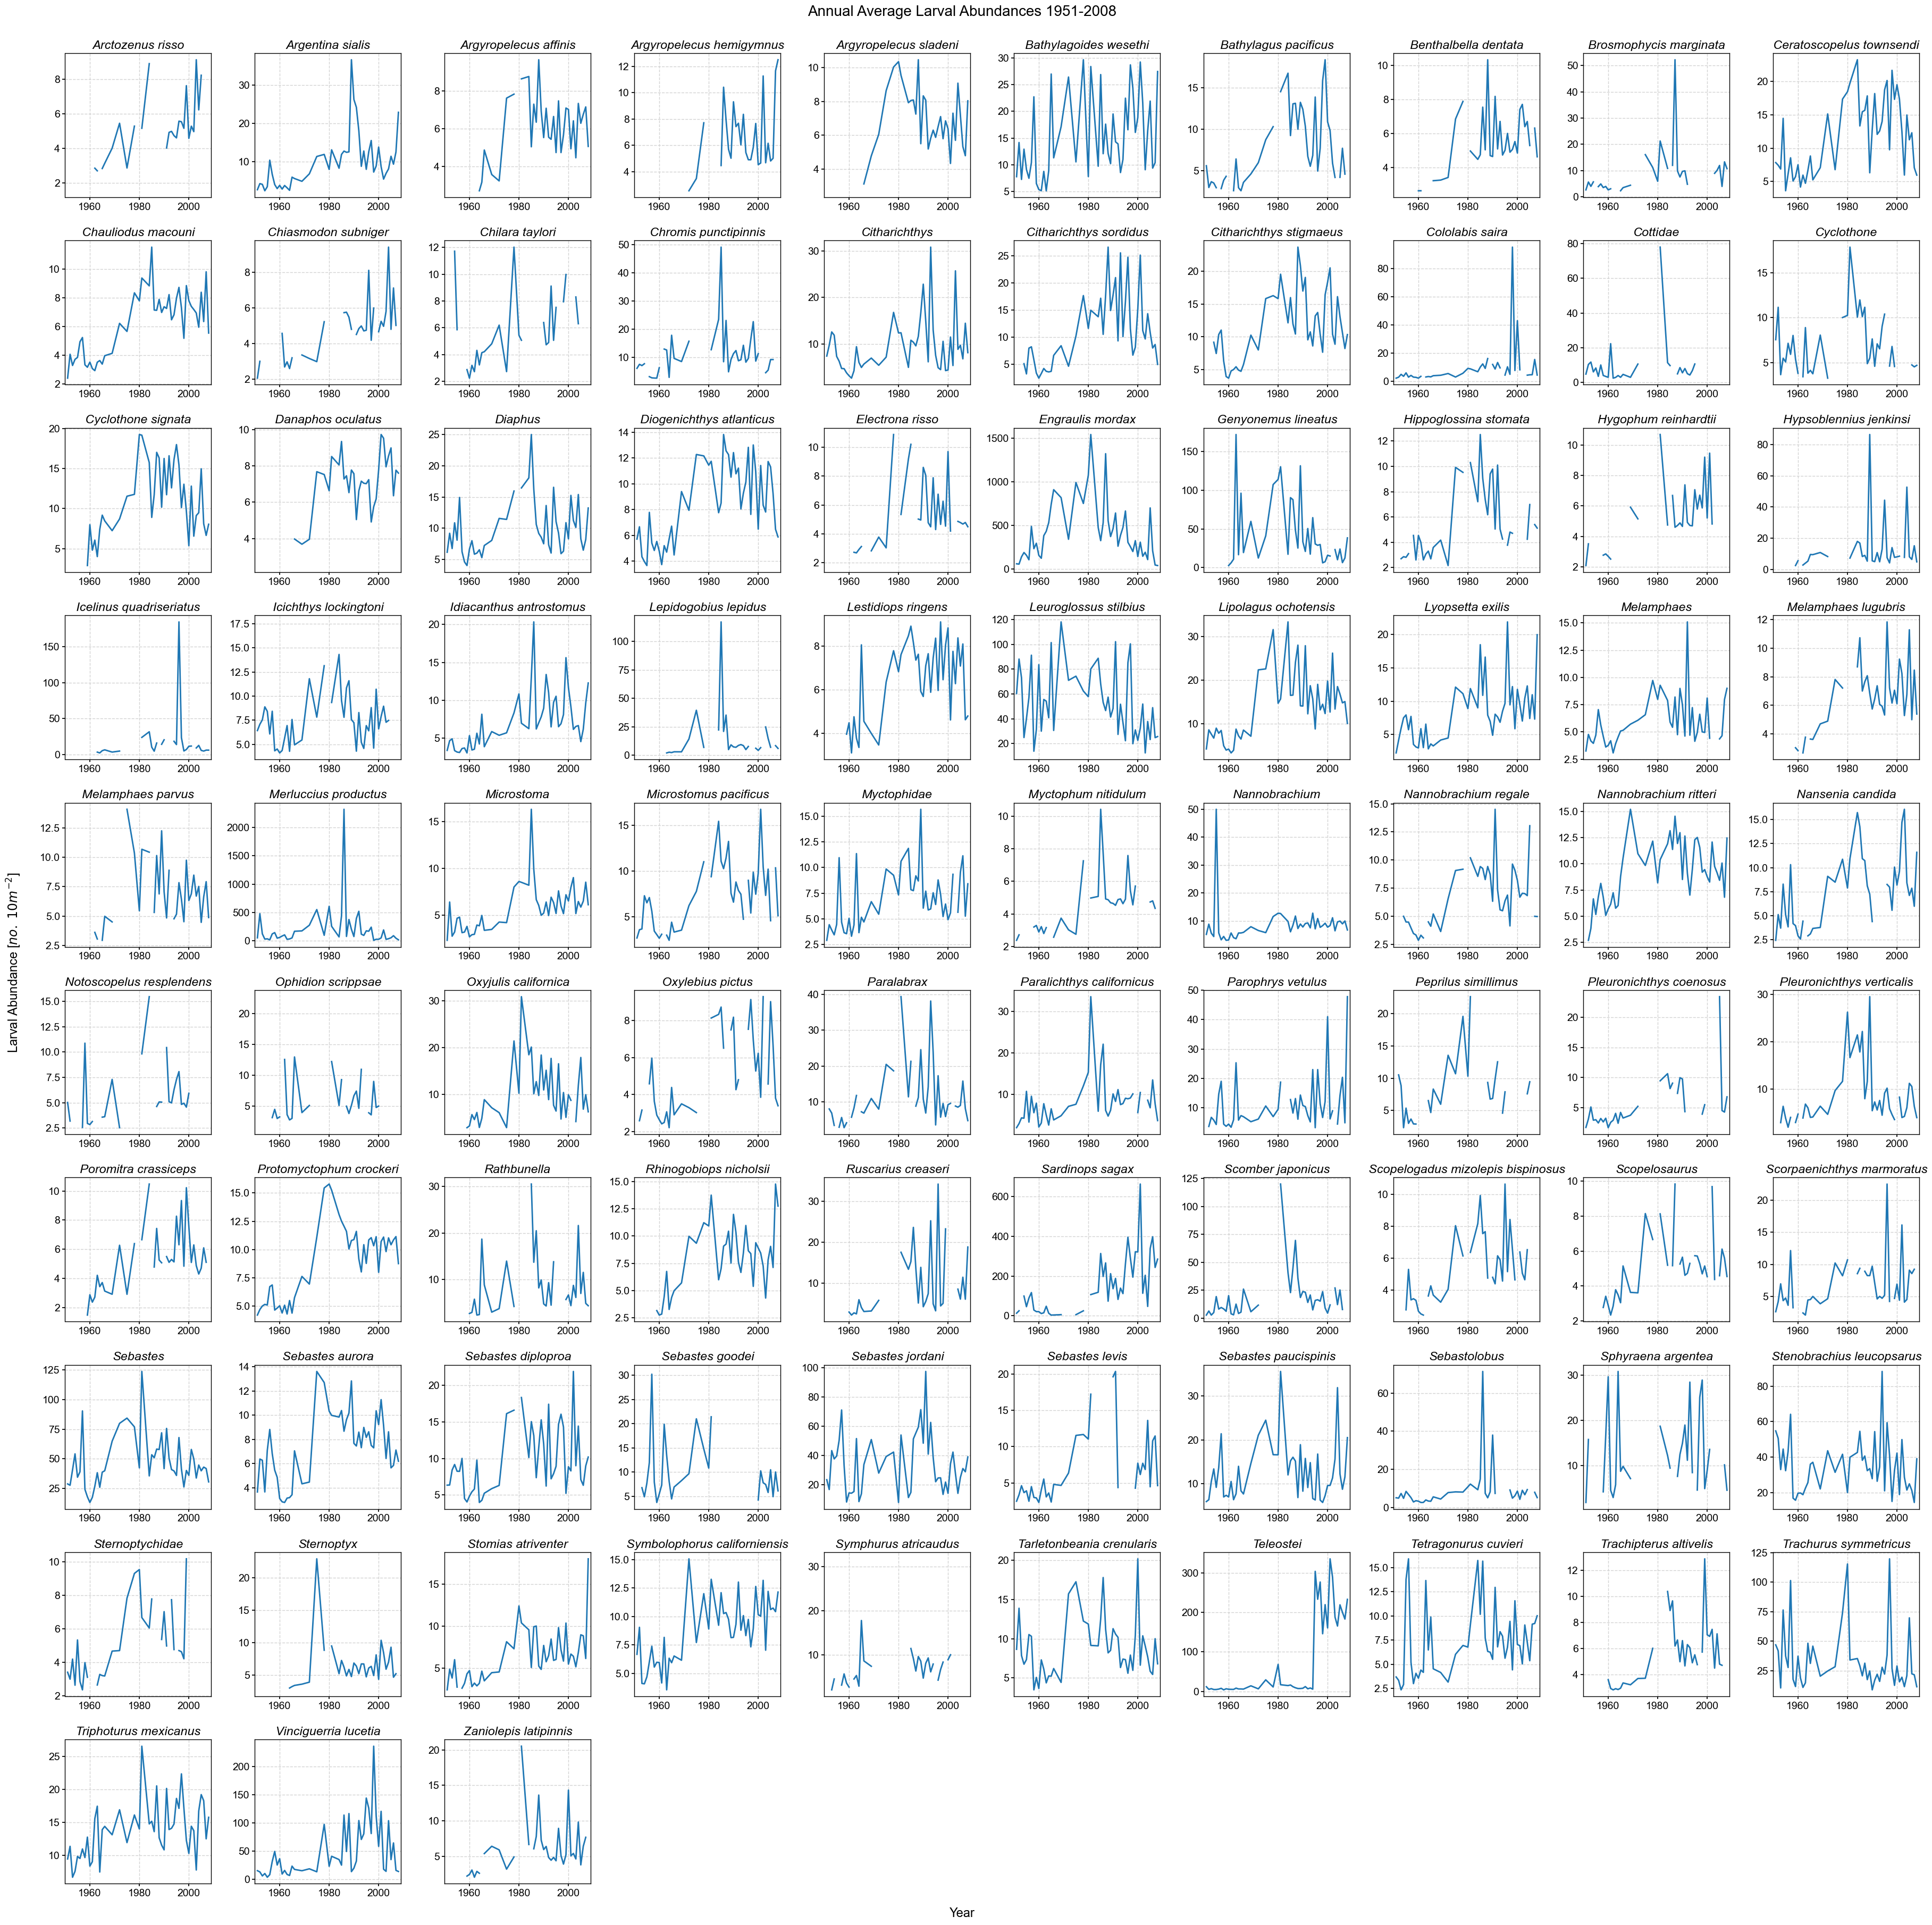

In [15]:
# pivot_longer to get a column for each species
annualMeansPlot = annualMeans.pivot_table(values="larvae_10m2", index="year", columns="scientific_name")

# plot set up
fig, axs = plt.subplots(nrows = 10, ncols = 10, # layout of subplots
                        figsize = (45,45)) # figure size
fig.subplots_adjust(wspace = 0.3, hspace = 0.3, bottom = 0.115, top = 0.88) # adjust white space in figure
fig.suptitle("Annual Average Larval Abundances 1951-2008", fontsize = 20, y = 0.9) # set overall title
fig.supxlabel("Year", fontsize = 17, y = 0.1) # set overall x axis label
fig.supylabel("Larval Abundance [$no. \ 10m^{-2}$]", fontsize = 17, x = 0.1) # set overall y axis label
plt.setp(axs, xlim = (1950, 2009)) # set overall x axis limits

# populate the subplots
for col, ax in zip(annualMeansPlot.columns, axs.ravel()):
    annualMeansPlot[[col]].plot(ax = ax)

    ax.set_title(col, style = "italic") # subplot title = taxon name in italics
    ax.get_legend().remove() # no subplot legend
    ax.set_xlabel("", fontsize = 16) #blank subplot xlabel
    ax.spines[["right", "top"]].set_visible(True) # make upper and right spines visible

# delete empty subplots
for i in range(3,10):
    fig.delaxes(axs[9, i])

# display the figure
plt.show()

# this cell should take about 40 secs to run

I will drop 'Teleostei' because that grouping is too broad. Then I will leave the rest of the taxa in.

In [16]:
# drop Teleostei
annualMeans = annualMeans[annualMeans["scientific_name"] != "Teleostei"]

# count the taxa remaining, there should be 92
display(len(annualMeans["scientific_name"].unique()))

92

Log-transform the annual means. The paper does not specify what kind of log transformation.

In [17]:
# the abundance figure (fig 2) in the paper has the abundance axis labeled as log(#/m^2)
annualMeans["larvae_m2"] = annualMeans["larvae_10m2"] / 10 # this conversion seems unlikely because it leads to small x values < 1 --> negative log(x) while the results in the figure are entirely ≥ 0. I think it may be a mistake and I will continue to use the larvae_10m2.

# apply log transformation to larvae_10m2. I will try a few different log transformations and see which matches the paper results most closely.
annualMeans["log10_larvae"] = np.log10(annualMeans["larvae_10m2"]) # log10(x)
annualMeans["ln_larvae"] = np.log(annualMeans["larvae_10m2"]) # ln(x)
annualMeans["ln_x1_larvae"] = np.log(annualMeans["larvae_10m2"] + 1) # ln(x + 1)

# show the first few columns
display(annualMeans.head())

,year,scientific_name,larvae_10m2,larvae_m2,log10_larvae,ln_larvae,ln_x1_larvae
1,1951,Argentina sialis,2.637500,0.263750,0.421192,0.969831,1.291297
2,1951,Bathylagoides wesethi,7.776321,0.777632,0.890774,2.051083,2.172057
3,1951,Bathylagus pacificus,5.600000,0.560000,0.748188,1.722767,1.887070
5,1951,Brosmophycis marginata,2.640000,0.264000,0.421604,0.970779,1.291984
6,1951,Ceratoscopelus townsendi,7.839722,0.783972,0.894301,2.059203,2.179255


***

### 2. Get and Process CalCOFI Oxygen Data

CalCOFI midwater oxygen data is included in the [Bottle Database](https://calcofi.org/data/oceanographic-data/bottle-database/).

Manual step: download CalCOFI bottle database and save as csv file.

Read in the data. Currently the bottle csv is just on my local device because it is too large to push to GitHub.

In [18]:
# the fourth column, Depth_ID, will be used as the index
oxygen = pd.read_csv("~/Desktop/PyRATES/pyrates/calcofi-bottle.csv",
                     index_col = 3)

Check the column names of the data.

In [19]:
display(oxygen.columns)

Index(['Cst_Cnt', 'Btl_Cnt', 'Sta_ID', 'Depthm', 'T_degC', 'Salnty', 'O2ml_L',
       'STheta', 'O2Sat', 'Oxy_micromol/Kg', 'BtlNum', 'RecInd', 'T_prec',
       'T_qual', 'S_prec', 'S_qual', 'P_qual', 'O_qual', 'SThtaq', 'O2Satq',
       'ChlorA', 'Chlqua', 'Phaeop', 'Phaqua', 'PO4uM', 'PO4q', 'SiO3uM',
       'SiO3qu', 'NO2uM', 'NO2q', 'NO3uM', 'NO3q', 'NH3uM', 'NH3q', 'C14As1',
       'C14A1p', 'C14A1q', 'C14As2', 'C14A2p', 'C14A2q', 'DarkAs', 'DarkAp',
       'DarkAq', 'MeanAs', 'MeanAp', 'MeanAq', 'IncTim', 'LightP', 'R_Depth',
       'R_TEMP', 'R_Sal', 'R_DYNHT', 'R_Nuts', 'R_Oxy_µmol/Kg', 'DIC1', 'DIC2',
       'TA1', 'TA2', 'pH1', 'pH2', 'DIC Quality Comment'],
      dtype='object')

View the first few rows of the data.

In [20]:
display(oxygen.head())

,Cst_Cnt,Btl_Cnt,Sta_ID,Depthm,T_degC,Salnty,O2ml_L,STheta,O2Sat,Oxy_micromol/Kg,...,R_DYNHT,R_Nuts,R_Oxy_µmol/Kg,DIC1,DIC2,TA1,TA2,pH1,pH2,DIC Quality Comment
Depth_ID,,,,,,,,,,,,,,,,,,,,,
19-4903CR-HY-060-0930-05400560-0000A-3,1,1,054.0 056.0,0,10.50,33.440,NaN,25.649,NaN,NaN,...,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19-4903CR-HY-060-0930-05400560-0008A-3,1,2,054.0 056.0,8,10.46,33.440,NaN,25.656,NaN,NaN,...,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19-4903CR-HY-060-0930-05400560-0010A-7,1,3,054.0 056.0,10,10.46,33.437,NaN,25.654,NaN,NaN,...,0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19-4903CR-HY-060-0930-05400560-0019A-3,1,4,054.0 056.0,19,10.45,33.420,NaN,25.643,NaN,NaN,...,0.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19-4903CR-HY-060-0930-05400560-0020A-7,1,5,054.0 056.0,20,10.45,33.421,NaN,25.643,NaN,NaN,...,0.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Subset for only the columns we need-- Sta_ID (contains line and station), Depthm, O2ml_L.

In [21]:
# get just the columns we need and drop NA values
oxygen = (oxygen.filter(items =["Sta_ID","Depthm", "O2ml_L"])
                .dropna())

# show the first few observations in the new dataframe
display(oxygen.head())

,Sta_ID,Depthm,O2ml_L
Depth_ID,,,
19-4904CR-HY-087-0606-04400485-0000B-3,044.0 048.5,0,5.90
19-4904CR-HY-087-0606-04400485-0006A-3,044.0 048.5,6,6.02
19-4904CR-HY-087-0606-04400485-0010A-7,044.0 048.5,10,6.04
19-4904CR-HY-087-0606-04400485-0015A-3,044.0 048.5,15,6.06
19-4904CR-HY-087-0606-04400485-0020A-7,044.0 048.5,20,6.04


Filter for the years 1951-2008. Date identifiers are included in the Depth_ID index; the first five characters are [Century]-[Year].

In [22]:
# extract the first five characters of the Depth_ID string and put them in a new column Year
oxygen = oxygen.assign(Year = oxygen.index.str[:5]) 

# remove the "-" character from the Year column
oxygen["Year"] = oxygen["Year"].str.replace(r'\-', '', regex=True)

# make the Year column numeric
oxygen["Year"] = pd.to_numeric(oxygen["Year"])

# filter for the years 1951-2008 and save the result in a new df
oxygen2 = oxygen.query("Year >= 1951 & Year <= 2008")

# show the last few rows
display(oxygen2.tail())

,Sta_ID,Depthm,O2ml_L,Year
Depth_ID,,,,
20-0810NM-MX-288-2117-09340264-0005A-3,093.4 026.4,5,5.96,2008
20-0810NM-MX-288-2117-09340264-0010A-3,093.4 026.4,10,5.62,2008
20-0810NM-MX-288-2117-09340264-0015A-3,093.4 026.4,15,5.28,2008
20-0810NM-MX-288-2117-09340264-0020A-7,093.4 026.4,20,5.11,2008
20-0810NM-MX-288-2117-09340264-0021A-3,093.4 026.4,21,5.08,2008


Filter for the select stations used in this study.

In [23]:
# split the "Sta_ID" column into a "line" column and "station" column and make those columns floats
oxygen2[["line", "station"]] = oxygen2["Sta_ID"].str.split(' ', n = 1, expand = True).astype('float64')

# inner join with the stations dataframe to keep only the rows with the correct line-stations
oxygen3 = (oxygen2.reset_index() # move the index to a regular column
                  .merge(stations,
                         how = "inner",
                         left_on = ["line", "station"],
                         right_on = ["line", "station"]) # do the merge
                  .set_index("Depth_ID")) # reset the Depth_ID column to index

# count the number of observations at each line-station
oxygenObservations = oxygen3.groupby(["line","station"]).size()

# count again to check there are 55 stations of data
display(len(oxygenObservations))

# show the first few rows
display(oxygen3.head())

55

,Sta_ID,Depthm,O2ml_L,Year,line,station
Depth_ID,,,,,,
19-5101CR-HY-017-0448-09001000-0000B-3,090.0 100.0,0,4.82,1951,90.0,100.0
19-5101CR-HY-017-0448-09001000-0020A-7,090.0 100.0,20,4.99,1951,90.0,100.0
19-5101CR-HY-017-0448-09001000-0030A-7,090.0 100.0,30,5.07,1951,90.0,100.0
19-5101CR-HY-017-0448-09001000-0050A-7,090.0 100.0,50,5.24,1951,90.0,100.0
19-5101CR-HY-017-0448-09001000-0075A-7,090.0 100.0,75,5.45,1951,90.0,100.0


Filter for depths 200-400m.

In [24]:
# query the Depthm column for values between 200 and 400
oxygen3 = oxygen3.query("Depthm >= 200 & Depthm <= 400")

# show the first few rows
display(oxygen3.head())

,Sta_ID,Depthm,O2ml_L,Year,line,station
Depth_ID,,,,,,
19-5101CR-HY-017-0448-09001000-0200A-7,090.0 100.0,200,4.59,1951,90.0,100.0
19-5101CR-HY-017-0448-09001000-0250A-7,090.0 100.0,250,3.94,1951,90.0,100.0
19-5101CR-HY-017-0448-09001000-0300A-7,090.0 100.0,300,3.13,1951,90.0,100.0
19-5101CR-HY-017-0448-09001000-0317A-3,090.0 100.0,317,2.81,1951,90.0,100.0
19-5101CR-HY-017-0448-09001000-0400A-7,090.0 100.0,400,1.71,1951,90.0,100.0


Assign seasons to the data.

In [25]:
# extract the month from the Depth_ID index
oxygen3 = oxygen3.assign(Month = oxygen3.index.str[5:7])
oxygen3["Month"] = pd.to_numeric(oxygen3["Month"]) # make numeric

# code the seasons based on the month column
oxygen3.loc[oxygen3.Month.isin([1,2]),"season"] = "Winter"
oxygen3.loc[oxygen3.Month.isin([3,4,5]),"season"] = "Spring"
oxygen3.loc[oxygen3.Month.isin([6,7,8]),"season"] = "Summer"
oxygen3.loc[oxygen3.Month.isin([9,10,11,12]),"season"] = "Fall"

# show the last few rows
display(oxygen3.tail())

,Sta_ID,Depthm,O2ml_L,Year,line,station,Month,season
Depth_ID,,,,,,,,
20-0810NM-MX-294-1156-09000350-0229A-3,090.0 035.0,229,1.90,2008,90.0,35.0,10,Fall
20-0810NM-MX-294-1156-09000350-0250A-7,090.0 035.0,250,1.54,2008,90.0,35.0,10,Fall
20-0810NM-MX-294-1156-09000350-0268A-3,090.0 035.0,268,1.25,2008,90.0,35.0,10,Fall
20-0810NM-MX-294-1156-09000350-0300A-7,090.0 035.0,300,1.09,2008,90.0,35.0,10,Fall
20-0810NM-MX-294-1156-09000350-0309A-3,090.0 035.0,309,1.04,2008,90.0,35.0,10,Fall


Remove years with < three seasons of data.

In [26]:
# for each year, count the number of seasons of data present
oxygenSeasons = (oxygen3.filter(items = ["Year", "season"])
           .groupby("Year") # group by year
           .nunique() # count the seasons each year has
           .rename(columns = {"season": "count"}) # name the count column "count"
           .reset_index() # ungroup
           )

# drop the years that have less than 3 seasons of data
oxygen3 = oxygen3.drop(
    oxygen3[oxygen3.Year.isin(oxygenSeasons.query("count < 3")["Year"])].index # get the index values matching this query
    ) # then drop those rows

# print the years remaining and the years that have been dropped
display(oxygen3["Year"].unique())
display(oxygenSeasons.query("count < 3")["Year"])

array([1951, 1952, 1953, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966,
       1969, 1975, 1978, 1983, 1984, 1985, 1986, 1988, 1989, 1990, 1991,
       1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002,
       2003, 2004, 2005, 2006, 2007, 2008, 1955, 1956, 1957, 1958, 1972])

15    1967
16    1968
18    1970
19    1971
21    1973
22    1974
24    1976
25    1977
27    1981
28    1982
33    1987
Name: Year, dtype: int64

Calculate seasonal means of midwater oxygen.

In [27]:
# group by year and season. then take the mean of the oxygen
seasonalOxygen = (oxygen3.filter(["Year","season", "O2ml_L"])
                         .groupby(["Year","season"]) # group by year, season
                         .mean() # take the mean of O2ml_L
                         .reset_index() # ungroup
                 )

# show the first few rows
display(seasonalOxygen.head())

,Year,season,O2ml_L
0,1951,Fall,1.666326
1,1951,Spring,1.702077
2,1951,Summer,1.563824
3,1951,Winter,1.708213
4,1952,Fall,1.508510


Calculate annual means of midwater oxygen.

In [28]:
# calculate annual means
annualOxygen = (seasonalOxygen.filter(["O2ml_L", "Year"]) # select oxygen and year columns
                              .groupby("Year") # group by year
                              .mean() # take the mean of O2ml_L
                              .reset_index() # ungroup
                )

# show the first few rows
display(annualOxygen.head())

,Year,O2ml_L
0,1951,1.660110
1,1952,1.662674
2,1953,1.560404
3,1955,1.456625
4,1956,1.516083


Plot annual midwater oxygen time series.

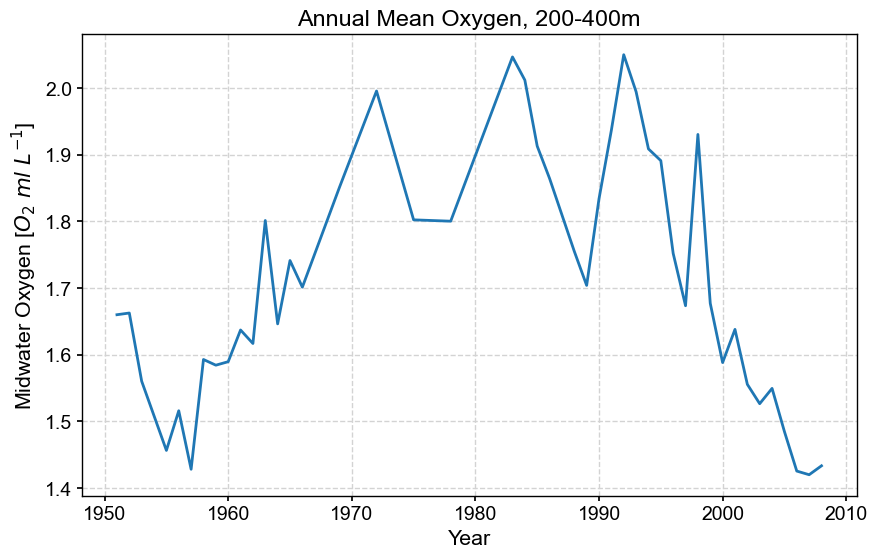

In [29]:
fig = plt.figure(figsize = (10, 6)) # set figure size

ax = fig.add_subplot(1, 1, 1) # subplot layout
ax.plot(annualOxygen["Year"], annualOxygen["O2ml_L"]); # variables to plot

ax.set_xlabel("Year") # set x axis label
ax.set_ylabel("Midwater Oxygen [$O_2 \ ml \  L^{-1}$]") # set y axis label
ax.set_title("Annual Mean Oxygen, 200-400m") # set figure title
ax.spines[["right", "top"]].set_visible(True) # make upper and right spines visible

# display plot
plt.show()

***

### 3. Analysis

#### 3.1 PCA

Standardize taxa by mean and standard deviation.

In [30]:
# take the annualMeans df, cast it so that each taxon is a column
pca_data = (annualMeans.filter(["year", "scientific_name", "log10_larvae"]) # select variables
                       .pivot_table(values = "log10_larvae",
                                    index = "year",
                                    columns = "scientific_name") # cast to get a column for each taxon, and a row for each year
                       .fillna(0) # replace any NaN with 0; no larvae of that taxon were observed in that year
                       .reset_index() # make year a regular column 
            )

# show the first few rows of the new df
print("Log-transformed species abundance data for PCA")
display(pca_data.head())

# standardize the features
features = pca_data.drop(columns=["year"]) # exclude the year column (index 0)

featsStScaled = StandardScaler().fit_transform(features) # StandardScaler's fit_transform method standardizes each column by its mean and standard deviation (z-score)

# show the first few rows of the scaled df
print("Standardized species abundance data for PCA")
featsStScaledDf = pd.DataFrame(data = featsStScaled)
display(featsStScaledDf.head())

# get min and max of each row of the scaled df to see the range of z-scores
featsStScaledRange = pd.DataFrame(
    {"scientific_name" : features.columns,
     "minimum" : featsStScaledDf.min(),
     "maximum" : featsStScaledDf.max()},
    columns = ["scientific_name", "minimum", "maximum"])

print("Min and Max Z Scores")
display(featsStScaledRange)

Log-transformed species abundance data for PCA


scientific_name,year,Arctozenus risso,Argentina sialis,Argyropelecus affinis,Argyropelecus hemigymnus,Argyropelecus sladeni,Bathylagoides wesethi,Bathylagus pacificus,Benthalbella dentata,Brosmophycis marginata,...,Stomias atriventer,Symbolophorus californiensis,Symphurus atricaudus,Tarletonbeania crenularis,Tetragonurus cuvieri,Trachipterus altivelis,Trachurus symmetricus,Triphoturus mexicanus,Vinciguerria lucetia,Zaniolepis latipinnis
0,1951,0.0,0.421192,0.0,0.0,0.0,0.890774,0.748188,0.0,0.421604,...,0.379003,0.824036,0.000000,0.936578,0.566437,0.0,1.671308,0.975078,1.176334,0.0
1,1952,0.0,0.627024,0.0,0.0,0.0,1.151380,0.471850,0.0,0.751352,...,0.685219,0.956352,0.000000,1.141884,0.522966,0.0,1.621566,1.055548,1.106171,0.0
2,1953,0.0,0.606560,0.0,0.0,0.0,0.861404,0.563876,0.0,0.601299,...,0.579784,0.613842,0.328380,0.895070,0.371068,0.0,1.018834,0.823852,0.757443,0.0
3,1954,0.0,0.374290,0.0,0.0,0.0,1.111419,0.544585,0.0,0.755951,...,0.777185,0.610487,0.661813,0.829248,0.463395,0.0,1.883124,0.878787,0.999565,0.0
4,1955,0.0,0.535294,0.0,0.0,0.0,0.960336,0.468347,0.0,0.000000,...,0.434569,0.670967,0.000000,0.865487,1.139052,0.0,1.574244,0.992511,0.527630,0.0


Standardized species abundance data for PCA


,0,1,2,3,4,5,6,7,8,9,...,82,83,84,85,86,87,88,89,90,91
0,-1.180145,-1.654829,-1.598624,-1.244911,-1.593998,-1.084030,0.096891,-1.450303,-0.375967,-0.548291,...,-1.620390,-0.609114,-1.232344,0.147805,-1.216356,-1.404311,0.889687,-1.110219,-0.696313,-1.464177
1,-1.180145,-0.938210,-1.598624,-1.244911,-1.593998,0.097767,-0.669966,-1.450303,0.367647,-0.651078,...,-0.252426,0.267697,-1.232344,1.335709,-1.425143,-1.404311,0.707468,-0.501872,-0.857591,-1.464177
2,-1.180145,-1.009456,-1.598624,-1.244911,-1.593998,-1.217218,-0.414587,-1.450303,0.029263,-0.807341,...,-0.723440,-2.001990,-0.474095,-0.092358,-2.154678,-1.404311,-1.500516,-2.253476,-1.659181,-1.464177
3,-1.180145,-1.818124,-1.598624,-1.244911,-1.593998,-0.083449,-0.468122,-1.450303,0.378018,0.659665,...,0.158415,-2.024220,0.295823,-0.473202,-1.711248,-1.404311,1.665632,-1.838168,-1.102637,-1.464177
4,-1.180145,-1.257576,-1.598624,-1.244911,-1.593998,-0.768581,-0.679687,-1.450303,-1.326723,-2.073359,...,-1.372161,-1.623442,-1.232344,-0.263528,1.533801,-1.404311,0.534113,-0.978421,-2.187433,-1.464177


Min and Max Z Scores


,scientific_name,minimum,maximum
0,Arctozenus risso,-1.180145,1.564915
1,Argentina sialis,-1.818124,2.322152
2,Argyropelecus affinis,-1.598624,1.216793
3,Argyropelecus hemigymnus,-1.244911,1.481256
4,Argyropelecus sladeni,-1.593998,1.146351
...,...,...,...
87,Trachipterus altivelis,-1.404311,1.706536
88,Trachurus symmetricus,-1.766274,2.379770
89,Triphoturus mexicanus,-2.253476,2.289009
90,Vinciguerria lucetia,-2.187433,2.052557


Perform PCA using scikit-learn.

In [31]:
# apply PCA
pca1 = PCA(n_components=2) # how many dimensions to reduce to
principalComponents = pca1.fit_transform(featsStScaled) # apply PCA on the features

principalDf = pd.DataFrame(data = principalComponents,
                           columns = ['PC1', 'PC2']) # extract PC1 and PC2

# concatenate the years to the PC1 and PC2 series
# for each row of data (each year), we get a PC1 score by taking the sum of [z-score (of each sci_name) * its value in the PC1 eigenvector]. PC2 is calculated the same way, thus we get a PC1 score and PC2 score for each row/year. in other words: each PC has a score for each observation of data (year). these scores are the coordinates from the projection of the original data onto the new 2D space defined by PC1 and PC2 axes.
finalDf = pd.concat([principalDf, pca_data[["year"]]], axis = 1)

# show the first few years of PC1 and PC2 scores
print("PC Scores")
display(finalDf.head())

# get the explained variance
print("Explained variance ratio:", pca1.explained_variance_ratio_)
print("Cumulative explained variance:", np.cumsum(pca1.explained_variance_ratio_))
print("")

# store the eigenvectors. eigenvectors are unit-scaled (always have a length of one) loadings, and are the coefficients for the linear combinations. each PC has an eigenvector which tells us about the direction of that line, and the eigenvector is a combination of different values (coefficients) for each variable (sci-name).
eigenvectors = pd.DataFrame(pca1.components_.T, columns = ["PC1", "PC2"])  # transpose to align with features
eigenvectorsDf = pd.concat([eigenvectors, pd.DataFrame(features.columns)], axis = 1) # add the sci_names back in
print("Eigenvectors")
display(eigenvectorsDf)

# eigenvalues are like the length of that line (PC), and tell us how much of the variance of the data are explained by this PC. they are what is visualized in the scree plot (sometimes represented as percentages of total variance explained) and what is often used to choose how many PCs to keep. they can be calculated by taking the variance of the PC scores, so each PC has one eigenvalue. the sum of the eigenvalues from all PCs will equal to the number of original variables (dimensions), in this case, 92.
print("PC1 eigenvalue:", finalDf["PC1"].var())
print("PC2 eigenvalue:", finalDf["PC2"].var())
print("")

# get the loadings. loadings are scaled eigenvectors. loading = eigenvector * sqrt(eigenvalue), and is equivalent to the correlation between the taxon timeseries and the PC1/PC2 timeseries, or how much of the explained variance is due to this variable. each variable (sci-name) has a loading on each PC
loadings = pd.DataFrame(pca1.components_.T * np.sqrt(pca1.explained_variance_), columns = ["PC1", "PC2"])
loadingsDf = pd.concat([loadings, pd.DataFrame(features.columns)], axis = 1) # add the sci_names back in
print("Loadings")
display(loadingsDf.sort_values(by = "PC1", ascending = False)) # sort by largest to smallest and display

PC Scores


,PC1,PC2,year
0,-11.848733,-0.282005,1951
1,-8.028537,1.717011,1952
2,-10.142865,3.091162,1953
3,-8.012253,2.129687,1954
4,-8.167124,3.591551,1955


Explained variance ratio: [0.3467651  0.06764922]
Cumulative explained variance: [0.3467651  0.41441433]

Eigenvectors


,PC1,PC2,scientific_name
0,0.111503,-0.125553,Arctozenus risso
1,0.142175,0.088052,Argentina sialis
2,0.161713,-0.065742,Argyropelecus affinis
3,0.144368,-0.008646,Argyropelecus hemigymnus
4,0.157205,0.018672,Argyropelecus sladeni
...,...,...,...
87,0.120769,-0.126352,Trachipterus altivelis
88,-0.010404,0.125727,Trachurus symmetricus
89,0.117639,-0.050764,Triphoturus mexicanus
90,0.113050,-0.147688,Vinciguerria lucetia


PC1 eigenvalue: 32.59591981543347
PC2 eigenvalue: 6.359026840389924

Loadings


,PC1,PC2,scientific_name
2,0.923263,-0.165783,Argyropelecus affinis
21,0.913029,-0.009673,Danaphos oculatus
4,0.897530,0.047087,Argyropelecus sladeni
10,0.886793,0.211186,Chauliodus macouni
61,0.886707,0.268066,Protomyctophum crockeri
...,...,...,...
19,0.038974,0.093558,Cyclothone
75,-0.040674,0.328038,Sebastes levis
88,-0.059402,0.317048,Trachurus symmetricus
18,-0.215585,0.073260,Cottidae


Plot PC1 timeseries.

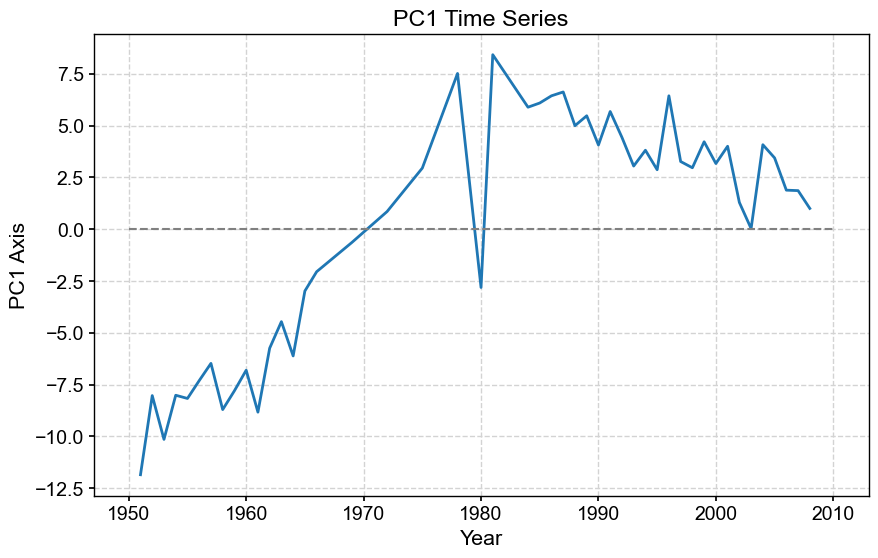

In [32]:
fig = plt.figure(figsize = (10, 6)) # set figure size

ax = fig.add_subplot(1, 1, 1) # subplot layout
ax.plot(finalDf["year"], finalDf["PC1"]); # variables to plot

ax.hlines(y = 0, xmin = 1950, xmax = 2010,
          colors='gray', linestyles='--', lw = 1.5) # add a y=0 line

ax.set_xlabel("Year") # set x axis label
ax.set_ylabel("PC1 Axis") # set y axis label
ax.set_title("PC1 Time Series") # set figure title
ax.spines[["right", "top"]].set_visible(True) # make upper and right spines visible

# display plot
plt.show()


#### 3.2 Detrending

One way the paper addressed bias is via detrending the PC1 time series. The Koslow paper just removes the linear trend, but here I will just show all three methods in pyleoclim.

Time axis values sorted in ascending order


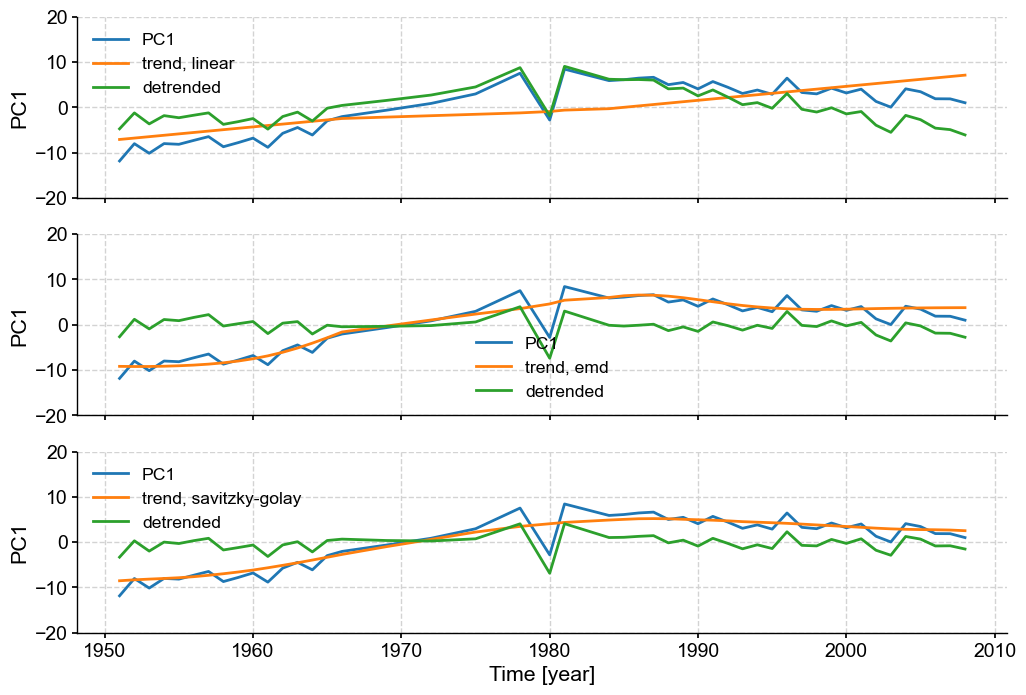

In [33]:
# make pc1 as a PyleoSeries
PC1ps = pyleo.Series(time = finalDf["year"],
                      value = finalDf["PC1"],
                      time_name = "Time", time_unit = "year", value_name = "PC1",
                      label = "PC1")

# pyleoclim has 3 methods for detrending
methods  = ["linear", "emd", "savitzky-golay"]

# set up plot
fig, axs = plt.subplots(3, 1, figsize = (12,8), sharex = True)
axs = axs.flatten()

# then for each of the 3 methods...
for i, mthd in enumerate(methods):

    PC1ps_dtd = PC1ps.detrend(method = mthd, keep_log=True) # detrend

    trend = PC1ps.copy()
    trend.value = PC1ps_dtd.log[0]["previous_trend"] # retrieve the trend

    # silence x axis label for the first two subplots
    if mthd == "savitzky-golay":
        PC1ps.plot(ax = axs[i], ylim = (-20, 20)) # plot original PC1
        trend.plot(ax = axs[i], label = ("trend, " + mthd), ylim = (-20, 20)) # plot the trend of PC1
        PC1ps_dtd.plot(ax = axs[i], label = "detrended", ylim = (-20, 20)) # plot detrended version of PC1
    else:
        PC1ps.plot(ax = axs[i], ylim = (-20, 20), xlabel = " ") # plot original PC1
        trend.plot(ax = axs[i], label = ("trend, " + mthd), ylim = (-20, 20), xlabel = " ") # plot the trend of PC1
        PC1ps_dtd.plot(ax = axs[i], label = "detrended", ylim = (-20, 20), xlabel = " ") # plot detrended version of PC1

Plot linear detrended PC1 by itself since we will move forward with this one.

(<Figure size 1000x400 with 1 Axes>,
 <Axes: title={'center': 'PC1 with linear trend removed'}, xlabel='Time [year]', ylabel='PC1'>)

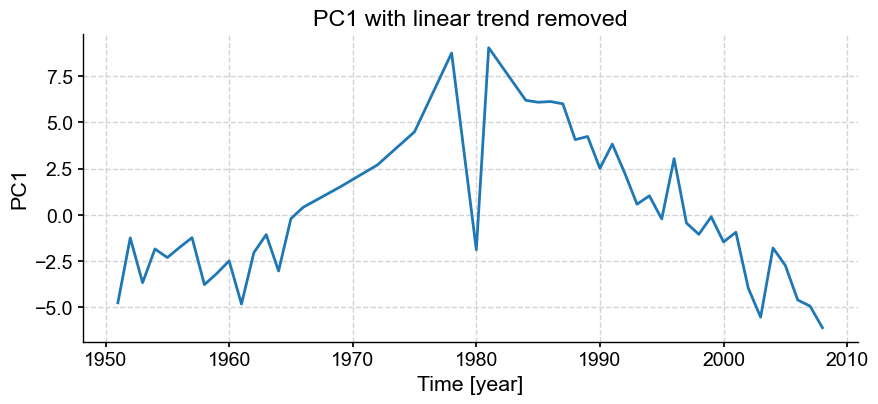

In [34]:
# remove the linear trend from PC1
PC1ps_dtd = PC1ps.detrend(method = "linear")

# plot the detrended PC1
PC1ps_dtd.plot(title = "PC1 with linear trend removed", legend = False)

#### 3.3 First-Differencing

Another way the Koslow paper addressed bias is via first-differencing, where value at t is equally to original value at t – original value at (t - 1). Prior to first-differencing the time series, remove the period of intermittent sampling (1967 to 1983). 

Here we will take the first-difference for PC1.

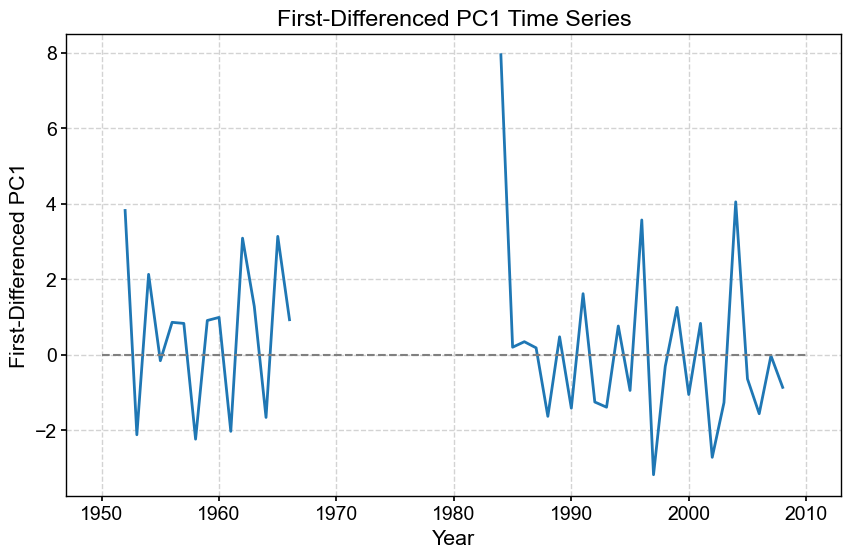

In [35]:
# to prepare for first-differencing, start with the original PC1 scores and remove the years of intermittent CalCOFI sampling (1967 to 1983).
PC1_fdd = finalDf.loc[(finalDf["year"] < 1967) | (finalDf["year"] > 1983), ["PC1", "year"]]

# first-differencing on PC1 time series
PC1_fdd["PC1_firstdiff"] = PC1_fdd["PC1"].diff()

# add NaN rows so that the plotted line breaks during the removed years
for i in np.arange(1951, 2008, 1):
    if i not in PC1_fdd["year"].values:
        PC1_fdd.loc[-1] = [np.nan, i, np.nan]  # adding a row
        PC1_fdd.index = PC1_fdd.index + 1  # shifting index
        PC1_fdd = PC1_fdd.sort_index()
    else:
        pass

# after adding the NaN rows, sort by year again
PC1_fdd = PC1_fdd.sort_values("year", ascending = True).set_index("year").reset_index()

# plot first-differenced PC1
fig = plt.figure(figsize = (10, 6)) # set figure size

ax = fig.add_subplot(1, 1, 1) # subplot layout
ax.plot(PC1_fdd["year"], PC1_fdd["PC1_firstdiff"]); # variables to plot

ax.hlines(y = 0, xmin = 1950, xmax = 2010,
          colors='gray', linestyles='--', lw = 1.5) # add a y=0 line

ax.set_xlabel("Year") # set x axis label
ax.set_ylabel("First-Differenced PC1") # set y axis label
ax.set_title("First-Differenced PC1 Time Series") # set figure title
ax.spines[["right", "top"]].set_visible(True) # make upper and right spines visible

# display plot
plt.show()


We also need to first-difference for the midwater oxygen time series.

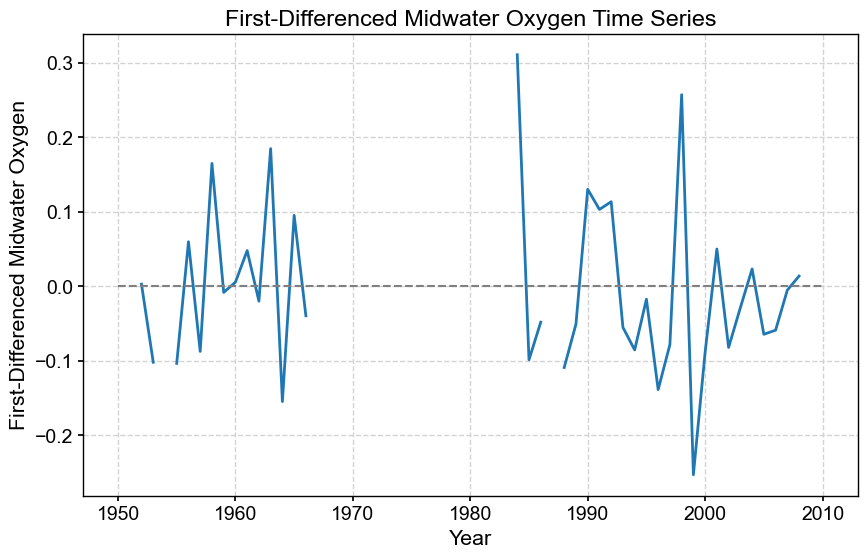

In [36]:
# to prepare for first-differencing, start with the original annual oxygen data and remove the years of intermittent CalCOFI sampling (1967 to 1983).
annualOxygen_fdd = annualOxygen.loc[(annualOxygen["Year"] < 1967) | (annualOxygen["Year"] > 1983), ["O2ml_L", "Year"]]

# first-differencing on the midwater oxygen time series
annualOxygen_fdd["O2_firstdiff"] = annualOxygen_fdd["O2ml_L"].diff()

# add NaN rows so that the plotted line breaks during the removed years
for i in np.arange(1951, 2008, 1):
    if i not in annualOxygen_fdd["Year"].values:
        annualOxygen_fdd.loc[-1] = [np.nan, i, np.nan]  # adding a row
        annualOxygen_fdd.index = annualOxygen_fdd.index + 1  # shifting index
        annualOxygen_fdd = annualOxygen_fdd.sort_index() # sort index
    else:
        pass

# after adding the NaN rows, sort by year again
annualOxygen_fdd = annualOxygen_fdd.sort_values("Year", ascending = True).set_index("Year").reset_index()


# plot first-differenced O2
fig = plt.figure(figsize = (10, 6)) # set figure size

ax = fig.add_subplot(1, 1, 1) # subplot layout
ax.plot(annualOxygen_fdd["Year"], annualOxygen_fdd["O2_firstdiff"]); # variables to plot

ax.hlines(y = 0, xmin = 1950, xmax = 2010,
          colors='gray', linestyles='--', lw = 1.5) # add a y=0 line

ax.set_xlabel("Year") # set x axis label
ax.set_ylabel("First-Differenced Midwater Oxygen") # set y axis label
ax.set_title("First-Differenced Midwater Oxygen Time Series") # set figure title
ax.spines[["right", "top"]].set_visible(True) # make upper and right spines visible

# display plot
plt.show()


We also need to take the first-difference for each taxa abundance time series.

In [37]:
# to prepare for first-differencing, start with the original annual ichthyo abundance data and remove the years of intermittent CalCOFI sampling (1967 to 1983).
taxa_for_fdd = annualMeans.loc[(annualMeans["year"] < 1967) | (annualMeans["year"] > 1983),
                                    ["scientific_name", "year", "log10_larvae"]]

# show the first few rows of data
display(taxa_for_fdd.head())

# create empty dictionaries for the next step
annualMeans_fdd = dict()
taxa_ts = dict()
firstdiff_list = dict()

# first-differencing on the taxa abundance time series
for i in taxa_for_fdd["scientific_name"].unique(): # for each taxon
    taxa_ts[i] = taxa_for_fdd.loc[taxa_for_fdd.scientific_name == i,:] # filter the df for this taxon
    firstdiff_list[i] = taxa_ts[i]["log10_larvae"].diff() # first-difference

    annualMeans_fdd[i] = pd.DataFrame({
        "scientific_name" : i,
        "year" : taxa_ts[i]["year"],
        "log10_larvae" : taxa_ts[i]["log10_larvae"],
        "taxa_firstdiff" : firstdiff_list[i]
    }) # then append the information for this taxon into the dictionary as a dataframe


# the keys of the dictionary are the taxa names
print(annualMeans_fdd.keys())

# access the first taxon to check
display(annualMeans_fdd["Argentina sialis"].head())

,scientific_name,year,log10_larvae
1,Argentina sialis,1951,0.421192
2,Bathylagoides wesethi,1951,0.890774
3,Bathylagus pacificus,1951,0.748188
5,Brosmophycis marginata,1951,0.421604
6,Ceratoscopelus townsendi,1951,0.894301


dict_keys(['Argentina sialis', 'Bathylagoides wesethi', 'Bathylagus pacificus', 'Brosmophycis marginata', 'Ceratoscopelus townsendi', 'Chauliodus macouni', 'Chiasmodon subniger', 'Chromis punctipinnis', 'Citharichthys', 'Cololabis saira', 'Cottidae', 'Cyclothone', 'Diaphus', 'Diogenichthys atlanticus', 'Electrona risso', 'Engraulis mordax', 'Hygophum reinhardtii', 'Icichthys lockingtoni', 'Idiacanthus antrostomus', 'Leuroglossus stilbius', 'Lipolagus ochotensis', 'Lyopsetta exilis', 'Melamphaes', 'Merluccius productus', 'Microstoma', 'Microstomus pacificus', 'Myctophidae', 'Myctophum nitidulum', 'Nannobrachium', 'Nansenia candida', 'Notoscopelus resplendens', 'Ophidion scrippsae', 'Paralichthys californicus', 'Pleuronichthys coenosus', 'Pleuronichthys verticalis', 'Protomyctophum crockeri', 'Sardinops sagax', 'Scomber japonicus', 'Scorpaenichthys marmoratus', 'Sebastes', 'Sebastes aurora', 'Sebastes diploproa', 'Sebastes goodei', 'Sebastes jordani', 'Sebastes levis', 'Sebastes paucispi

,scientific_name,year,log10_larvae,taxa_firstdiff
1,Argentina sialis,1951,0.421192,NaN
90,Argentina sialis,1952,0.627024,0.205832
182,Argentina sialis,1953,0.606560,-0.020464
262,Argentina sialis,1954,0.374290,-0.232271
358,Argentina sialis,1955,0.535294,0.161004


#### 3.4 Correlations Taxafdd_PC1fdd

Calculate taxa correlations for first-differenced time series

In [38]:
# correlate each unique taxafdd with PC1fdd

# create empty df and dictionaries to iterate over
pearsons = pd.DataFrame(columns = ["scientific_name", "r", "pvalue"])
ichthyo = dict()
ichthyo_PC1 = dict()
corr = dict()
p = dict()

# for each taxon:
for i in annualMeans_fdd.keys():
    ichthyo_PC1[i] = (pd.merge(PC1_fdd, annualMeans_fdd[i], how = "inner", on = "year") 
                          .sort_values("year", ascending = True)
                          .dropna()
                          ) # inner merge with PC1 timeseries
    
    corr[i], p[i] = pearsonr(ichthyo_PC1[i]["taxa_firstdiff"], ichthyo_PC1[i]["PC1_firstdiff"]) # compute pearson's correlation
    
    pearsons.loc[-1] = [i, corr[i], p[i]]  # adding a row with the sci_name, r, p-value
    pearsons.index = pearsons.index + 1  # shifting index
    pearsons = pearsons.sort_index() # sort index

# sort the df by r
pearsons = pearsons.sort_values("r", ascending = False)

# show the first few rows
display(pearsons.head())


,scientific_name,r,pvalue
2,Icelinus quadriseriatus,0.663087,0.000413
66,Microstomus pacificus,0.644276,0.000017
17,Melamphaes lugubris,0.630910,0.000186
56,Protomyctophum crockeri,0.601686,0.000040
62,Nansenia candida,0.542007,0.000771


#### 3.5 Correlations taxa_oxygen

Calculate Spearman's rho correlations for taxa_oxygen

In [39]:
# for each taxon, correlate their log abundance timeseries with the original oxygen timeseries

# create empty df and dictionaries to iterate over
spearmans = pd.DataFrame(columns = ["scientific_name", "rho", "pvalue"])
ichthyo = dict()
ichthyo_oxygen = dict()
corr = dict()
p = dict()

# for each taxon:
for i in annualMeans["scientific_name"].unique():
    ichthyo[i] = (annualMeans.filter(["year", "scientific_name", "log10_larvae"]) # get needed columns
                            .loc[annualMeans.scientific_name == i,:] # get data for this specific taxon
                            .rename(columns = {"year" : "Year"}) # rename to match oxygen df column names
                            )
    
    ichthyo_oxygen[i] = (pd.merge(annualOxygen, ichthyo[i], how = "inner", on = "Year") 
                          .sort_values("Year", ascending = True)
                          ) # inner merge with oxygen timeseries
    
    corr[i], p[i] = spearmanr(ichthyo_oxygen[i]["O2ml_L"], ichthyo_oxygen[i]["log10_larvae"]) # compute spearman's correlation
    
    spearmans.loc[-1] = [i, corr[i], p[i]]  # adding a row with the sci_name, rho, p-value
    spearmans.index = spearmans.index + 1  # shifting index
    spearmans = spearmans.sort_index() # sort index

# sort the df by rho
spearmans = spearmans.sort_values("rho", ascending = False)

# show the first few rows
display(spearmans.head())


,scientific_name,rho,pvalue
20,Cyclothone signata,0.544402,0.000598
76,Engraulis mordax,0.529900,0.000258
84,Chromis punctipinnis,0.521811,0.000925
89,Bathylagus pacificus,0.518547,0.000852
87,Ceratoscopelus townsendi,0.487466,0.000915


#### 3.6 Correlations PC1_oxygen

Calculate Pearson correlations between: PC1 and oxygen; detrended PC1 and oxygen; first-differenced PC1 and first-differenced oxygen time series.

In [40]:
# Pearson correlation of original PC1 with original oxygen time series
# want to put the oxygen and PC1 data together in one df.
finalDf = finalDf.rename(columns = {"year" : "Year"}) # make column names the same

PC1_O2_na = (pd.merge(annualOxygen, finalDf, how = "inner", on = "Year") 
            .sort_values("Year")) # merge the dfs together

PC1_O2 = PC1_O2_na.dropna() # remove any years with NaN values

PC1_O2_corr, PC1_O2_p = pearsonr(PC1_O2["PC1"], PC1_O2["O2ml_L"]) # get Pearson's r
print('Original Pearson correlation: %.2f' % PC1_O2_corr) # print r
print('p-value: {:.2e}'.format(PC1_O2_p)) # print p-value

# Pearson correlation of detrended PC1 with original oxygen time series
PC1dtd = PC1ps_dtd.to_pandas().reset_index() # get the detrended pyleo Series, convert it to a Pandas series
PC1dtd = pd.DataFrame(data = PC1dtd).set_index("datetime") # make dataframe
PC1dtd["Year"] = PC1dtd.index.year # create year column for merging
PC1dtd_O2 = (pd.merge(annualOxygen, PC1dtd, how = "inner", on = "Year") 
                  .sort_values("Year")
                  .dropna()) # merge detrended PC1 with original oxygen time series

PC1dtd_O2_corr, PC1dtd_O2_p = pearsonr(PC1dtd_O2["PC1"], PC1dtd_O2["O2ml_L"]) # get Pearson's r
print('Detrended PC1 Pearson correlation: %.2f' % PC1dtd_O2_corr) # print r
print('p-value: {:.2e}'.format(PC1dtd_O2_p)) # print p-value

# Pearson correlation of first-diff PC1 with first-diff oxygen time series
PC1_fdd = PC1_fdd.rename(columns = {"year" : "Year"})  # rename to match column names with the oxygen series
PC1fdd_O2fdd = (pd.merge(annualOxygen_fdd, PC1_fdd, how = "inner", on = "Year") 
                  .sort_values("Year")
                  .dropna()) # merge first-diff PC1 with first-diff oxygen time series

PC1fdd_O2fdd_corr, PC1fdd_O2fdd_p = pearsonr(PC1fdd_O2fdd["PC1"], PC1fdd_O2fdd["O2ml_L"]) # get Pearson's r
print('First-Differenced Pearson correlation: %.2f' % PC1fdd_O2fdd_corr) # print r
print('p-value: {:.2e}'.format(PC1fdd_O2fdd_p)) # print p-value

# make a table with these correlations and their p-values
table3 = pd.DataFrame({"test" : ["PC1_O2", "PC1dtd_O2", "PC1fdd_O2fdd"],
                       "correlation" : [PC1_O2_corr, PC1dtd_O2_corr, PC1fdd_O2fdd_corr],
                       "pvalue" : [PC1_O2_p, PC1dtd_O2_p, PC1fdd_O2fdd_p]},
                       ) # save them together as a df

Original Pearson correlation: 0.46
p-value: 1.73e-03
Detrended PC1 Pearson correlation: 0.77
p-value: 1.48e-08
First-Differenced Pearson correlation: 0.49
p-value: 1.96e-03


***

### 4. Make Figures

Table 2 (partial): Taxa that contributed significantly to PC1 with:
1. scientific name
2. their loadings, equivalent to their correlations with the original PC1 timeseries
3. their correlations for first-differenced time series
4. their Spearman's rho correlations with the midwater oxygen time series

In [41]:
# start with loadings dataframe
table2 = (loadingsDf.filter(items = ["scientific_name", "PC1"])
                    .sort_values(by = "PC1", ascending = False)
          )

# add pearsons correl dataframe (Taxafdd_PC1fdd)
table2 = (pd.merge(table2, pearsons, how = "left", on = "scientific_name")
            .rename(columns = {"r" : "PC1fddcorrel",
                               "pvalue" : "PC1fddcorrelp"}))

# add spearmans correl dataframe (Taxa_O2)
table2 = (pd.merge(table2, spearmans, how = "left", on = "scientific_name")
            .rename(columns = {"scientific_name" : "Taxon",
                                "PC1" : "Loading",
                                "rho" : "O2correl",
                                "pvalue" : "O2correlp"}))

# use GT to format the table
table2_gt = (GT(table2)
             .tab_header(title = "Table 2") # table title
             .fmt_number(columns =["Loading", "PC1fddcorrel", "O2correl"], decimals = 2) # show r values to 2 decimal places
             .tab_style(style = style.text(style="italic"),
                        locations = loc.body(columns="Taxon")) # italicize scientific names
             .tab_style(style=style.fill(color="yellow"),
                        locations=loc.body(
                                             columns=lambda col_name: col_name.startswith("PC"),
                                             rows=lambda D: D["PC1fddcorrelp"] < 0.05,
                                                 )) # highlight cells with significant p-value
             .tab_style(style=style.fill(color="yellow"),
                        locations=loc.body(
                                             columns=lambda col_name: col_name.startswith("O2"),
                                             rows=lambda D: D["O2correlp"] < 0.05,
                                                 )) # highlight cells with significant p-value
             .cols_width(cases={"Taxon": "250px",
                                "Loading": "250px",
                                "PC1fddcorrel" : "250px",
                                "O2correl": "250px",
                                "PC1fddcorrelp" : "0px",
                                "O2correlp" : "0px"
                            }) # set column widths
             .cols_align(align = "center", columns = ["Loading", "PC1fddcorrel", "O2correl"]) # center-align text
             .cols_align(align = "left", columns = "Taxon") # left-align the left-most column
             .cols_label(Taxon = html("<strong>Taxon</strong>"),
                         Loading = html("<strong>Loading</strong>"),
                         PC1fddcorrel = html("<strong>First Diff correl.</strong>"),
                         O2correl = html("<strong><i>O<sub>2</sub></i> correl.</strong>")) # change and style the column labels
            

             # add footers
             .tab_source_note(source_note = ("Cells in the last two columns are highlighted where the associated p-value < 0.05."))
             .tab_source_note(source_note = html("<strong>Loading</strong> = loading on PC1, equivalent to the Pearson correlation between the ichthyoplankton abundance time series and the PC1 time series."))
             .tab_source_note(source_note = html("<strong>First Diff correl.</strong> = coefficient <i>r</i> of the Pearson correlation between the first-difference of the ichthyoplankton abundance time series and the first-difference of the PC1 time series."))
             .tab_source_note(source_note = html("<strong>O<sub>2</sub> correl.</strong> = coefficient &rho; of the Spearman correlation between the ichthyoplankton abundance time series and the midwater oxygen time series."))
             )

# save the table
table2_gt.save("Tab2-correlations.png")


Figure 2: Time series of four taxa that contributed significantly to PC1.

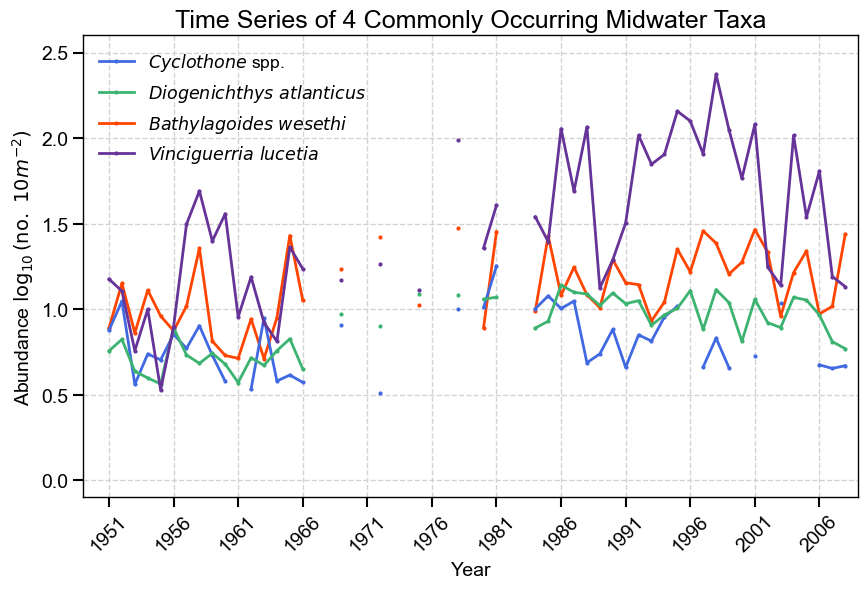

In [42]:
# the four taxa in this plot: Cyclothone spp., Diogenichthys atlanticus, Bathylagoides wesethi, Vinciguerria lucetia
# prepare df for plotting
fourTaxa = (annualMeans.filter(["year", "scientific_name", "log10_larvae"]) # get needed columns
            .loc[annualMeans.scientific_name.isin(["Cyclothone",
                                                   "Diogenichthys atlanticus",
                                                   "Bathylagoides wesethi",
                                                   "Vinciguerria lucetia"]),:] # get the four taxa in this figure
            )

# make a multi-index with all combinations of taxa and years
mux = pd.MultiIndex.from_product([
        fourTaxa.scientific_name.unique(),
        range(fourTaxa.year.min(), fourTaxa.year.max() + 1)
    ], names=['scientific_name', 'year'])

# use the multi-index to make NaN rows when a taxon is not observed in a given year. if there are no NaN rows, then the line plot will connect datapoints even if there are several-year-long gaps in sampling between them
fourTaxa = fourTaxa.set_index(['scientific_name', 'year']).reindex(mux).reset_index()

# figure layout
fig = plt.figure(figsize = (10, 6)) # set figure size
ax = fig.add_subplot(1, 1, 1) # subplot layout

# set colors-- choosing similar colors to those in the Koslow paper
ax.set_prop_cycle(color=['orangered', 'royalblue', 'mediumseagreen', 'rebeccapurple'])

# plot each of the four taxa
for i in fourTaxa.scientific_name.unique():
    # using a conditional statement for the legend labels. if sci_name is a genus and not a specific spp (recognized via lack of whitespace), make the label sci_name + 'spp.', else label it by sci_name. 
    if " " not in i:
        ax.plot(fourTaxa.loc[fourTaxa["scientific_name"] == i, "year"], # x variable
        fourTaxa.loc[fourTaxa["scientific_name"] == i, "log10_larvae"], # y variable
        '-o', ms = 2, # marker type and marker size
        label = "$\it{{{taxaLabel}}}$ spp.".format(taxaLabel = i)) # legend label
    else:
        ax.plot(fourTaxa.loc[fourTaxa["scientific_name"] == i, "year"], # x variable
            fourTaxa.loc[fourTaxa["scientific_name"] == i, "log10_larvae"], # y variable
            '-o', ms = 2, # marker type and marker size
            label = "$\it{{{taxaLabel}}}$".format(taxaLabel = i.replace(" ", "\ "))) # legend label. the replace() is needed here so that the surrounding mathtext will include the whitespace between the genus and species.

# set axes labels, limits, ticks, spines
ax.set_xlabel("Year", fontsize = 14) # set x axis label
ax.set_xlim(1949, 2009) # set x axis limits
ax.set_xticks(np.arange(1951, 2011, 5)) # set x axis ticks
ax.tick_params(axis = "x", labelrotation = 45) # rotate x axis labels

ax.set_ylabel("Abundance $\log_{10}(\mathrm{no.} \ 10m^{-2})$", fontsize = 14) # set y axis label
ax.set_ylim(-0.1, 2.6) # set y axis limits
ax.set_yticks(np.arange(0.0, 3, 0.5)) # set y axis ticks

ax.tick_params(axis = "both", length = 7, width = 1.5) # set length and width of axis ticks

ax.spines[["right", "top"]].set_visible(True) # make upper and right spines visible

# set figure title
ax.set_title("Time Series of 4 Commonly Occurring Midwater Taxa", fontsize = 18)

# add a legend
handles, labels = plt.gca().get_legend_handles_labels()
order = [1,2,0,3] # adjust the order of the legend items to match the order in the Koslow paper
legend = ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order]) # make the legend

# save plot
plt.savefig('Fig2-four-common-taxa.png', bbox_inches='tight') # bbox arg removes undesired whitespace around image

# display plot
plt.show()

Figure 3: Time series of PC1 and mean midwater oxygen (200-400m).

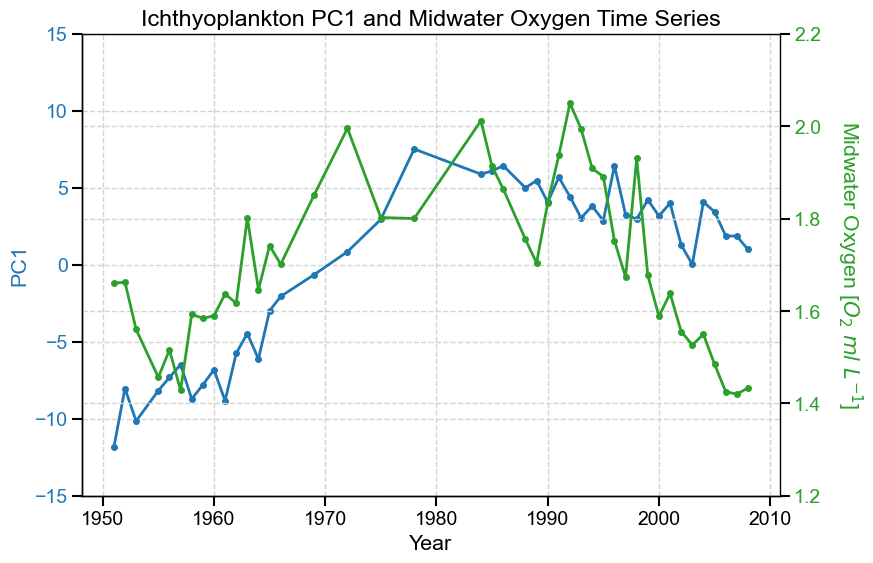

In [43]:
# plot the original PC1 and midwater oxygen time series together.
# set up figure
fig = plt.figure(figsize = (9, 6)) # set figure size

# first Axes object: PC1 time series
ax1 = fig.add_subplot(1, 1, 1) # subplot layout

color = "tab:blue" # set a color for this series
ax1.plot(PC1_O2_na["Year"], PC1_O2_na["PC1"], '-o', ms = 4, color = color) # variables to plot, markers, color
ax1.set_xlabel("Year") # x-axis label
ax1.set_ylabel("PC1", color = color) # y-axis label
ax1.set_ylim(-15.00, 15.00) # y-axis limits
ax1.set_title("Ichthyoplankton PC1 and Midwater Oxygen Time Series") # overall title
ax1.tick_params(axis = "y", labelcolor = color) # y-axis color
ax1.tick_params(axis = "both", length = 7, width = 1.5) # length and width of axis ticks

ax2 = ax1.twinx() # initiate another Axes object, sharing the same x-axis

color2 = "tab:green" # set a color for this series
ax2.plot(PC1_O2_na["Year"], PC1_O2_na["O2ml_L"], '-o', ms = 4, color = color2) # variables to plot, markers, color
ax2.set_ylabel("Midwater Oxygen [$O_2 \ ml \  L^{-1}$]", color = color2, rotation = -90, va = "center", labelpad = 20) # y-axis label, rotated. labelpad arg is required otherwise the label will overlap with the ticks
# x-axis label and title are already set in the first Axes object
ax2.set_ylim(1.20, 2.20) # y-axis limits
ax2.tick_params(axis = "y", labelcolor = color2) # y-axis color
ax2.tick_params(axis = "both", length = 7, width = 1.5) # length and width of axis ticks

# make the upper and right side borders (spines) visible
ax2.spines[["right", "top"]].set_visible(True)

# save figure
plt.savefig('Fig3-PC1-oxygen.png', bbox_inches='tight') # bbox arg removes undesired whitespace around image

# print the plot
plt.show()

Table 3 (partial): Pearson correlations of PC1 with mean midwater oxygen (200-400m) before and after detrending and first-differencing. 

In [44]:
# use GT to format the table
table3_gt = (GT(table3)
             .tab_header(title = "Table 3") # table title
             .fmt_number(columns = "correlation", decimals = 2) # show the r values to 2 decimal places
             .fmt_scientific(columns = "pvalue", decimals = 2) # show the p-values in scientific notation with 2 decimal places
             .cols_width(cases={"test": "120px",
                                "correlation": "120px",
                                "pvalue": "120px",
                            }) # set column widths
             .cols_align(align = "center", columns = ["correlation", "pvalue"]) # center-align text
             .cols_align(align = "left", columns = "test") # left-align the left-most column
             .cols_label(test = html("<strong>Test</strong>"), correlation = html("<strong>Pearson <i>r</i></strong>"),
                        pvalue = html("<strong><i>p</i>-value</strong>")) # change and style the column labels
            
            # add footers
             .tab_source_note(source_note = html("Tests in the format <i>x_y</i> for <i>pearsonr(x, y)</i>."))
             .tab_source_note(source_note = html("<i>PC1</i> = Principal Component 1 of CalCOFI ichthyoplankton abundance time series,<br><i>O2</i> = CalCOFI midwater oxygen time series"))
             .tab_source_note(source_note = html("<i>dtd</i> = detrended, <i>fdd</i> = first-differenced"))
             ) 

# save the table
table3_gt.save("Tab3-correlations.png")

display(table3_gt) # print the table

GT(_tbl_data=           test  correlation        pvalue
0        PC1_O2     0.463842  1.731144e-03
1     PC1dtd_O2     0.771064  1.476566e-08
2  PC1fdd_O2fdd     0.486344  1.961959e-03, _body=<great_tables._gt_data.Body object at 0x13fe0ce90>, _boxhead=Boxhead([ColInfo(var='test', type=<ColInfoTypeEnum.default: 1>, column_label=Html(text='<strong>Test</strong>'), column_align='left', column_width='120px'), ColInfo(var='correlation', type=<ColInfoTypeEnum.default: 1>, column_label=Html(text='<strong>Pearson <i>r</i></strong>'), column_align='center', column_width='120px'), ColInfo(var='pvalue', type=<ColInfoTypeEnum.default: 1>, column_label=Html(text='<strong><i>p</i>-value</strong>'), column_align='center', column_width='120px')]), _stub=<great_tables._gt_data.Stub object at 0x13f9aa610>, _spanners=Spanners([]), _heading=Heading(title='Table 3', subtitle=None, preheader=None), _stubhead=None, _source_notes=[Html(text='Tests in the format <i>x_y</i> for <i>pearsonr(x, y)</i>.'), Html(text='<i>PC1</i> = Principal Component 1 of CalCOFI ichthyoplankton abundance time series,<br><i>O2</i> = CalCOFI midwater oxygen time series'), Html(text='<i>dtd</i> = detrended, <i>fdd</i> = first-differenced')], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x13fabba90>, _formats=[<great_tables._gt_data.FormatInfo object at 0x13f600bd0>, <great_tables._gt_data.FormatInfo object at 0x13f603150>], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_right_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_right_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_right_color=OptionsInfo(scss=True, category='table', type='value', value='#D3D3D3'), table_border_bottom_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_bottom_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_bottom_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_bottom_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_left_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_left_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_left_co